In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
def filter_pvalue(df, pvalue_range):
    df = df[df['Pvalue'].apply(lambda x: x <= pvalue_range[0] or x >= pvalue_range[1])].copy()
    df['Target'] = df['Pvalue'].apply(lambda x: 1 if x < np.mean(pvalue_range) else 0)
    return df

In [4]:
def evaluate(train, test):
    model = SGDClassifier(loss='log', max_iter=100)
    model.fit(train[[col for col in train.columns if 'cause' in col or 'effect' in col]], train['Target'])
    y_pred = model.predict(test[[col for col in test.columns if 'cause' in col or 'effect' in col]])
    print(accuracy_score(test['Target'], y_pred))
    print(f1_score(test['Target'], y_pred))
    return f1_score(test['Target'], y_pred)

In [11]:
folds = os.listdir('Raw')

In [12]:
test = None
train = None
y_pred = None

In [13]:
col_types = {
    'CauseGene': 'category',
    'EffectGene': 'category',
    'Replicate': 'category',
    'Treatment': 'category'
}

In [72]:
scores = []
for idx, test_fold in enumerate(folds):
    if idx <= 1: continue
    print(f'Test fold: {test_fold}')
    test = pd.read_csv(f'Raw/{test_fold}', sep = ';', dtype=col_types)
    train = pd.DataFrame(columns = test.columns)
    for train_fold in [fold for fold in folds if fold != test_fold]:
        print(f'Train fold: {train_fold}')
        train = pd.concat((train, pd.read_csv(f'Raw/{train_fold}',sep = ';', dtype=col_types)))
    train = train.reset_index(drop=True)
    
    test = filter_pvalue(test, (0.01, 0.5))
    train = filter_pvalue(train, (0.01, 0.5))
    
#     score = evaluate(train, test)
#     print(f'Score: {score}')
#     scores += score
    
    break

Test fold: Jnk.csv
Train fold: CTNNB1.csv
Train fold: LEF1.csv
Train fold: Erk.csv
Train fold: IRF4.csv
Train fold: MYC.csv
Train fold: Ikk2.csv


In [15]:
train.shape, test.shape, 

((691542, 24), (82038, 24))

In [18]:
x = [float(x.split('m')[0]) for x in \
     train.loc[0,[c for c in train if c.endswith('cause')]].index]

In [19]:
x

[0.0, 15.0, 30.0, 90.0, 120.0, 180.0, 210.0, 240.0, 360.0]

In [20]:
y = train.loc[0,[c for c in train if c.endswith('cause')]]

In [41]:
[c.startswith('90') for c in y.index]

[False, False, False, True, False, False, False, False, False]

In [39]:
y

0min_neg_cause    0.777138
15min_cause        0.62156
30min_cause       0.762682
90min_cause       0.949396
120min_cause     -0.388986
180min_cause      -1.19022
210min_cause      -1.31899
240min_cause      -1.81522
360min_cause      -1.35419
Name: 0, dtype: object

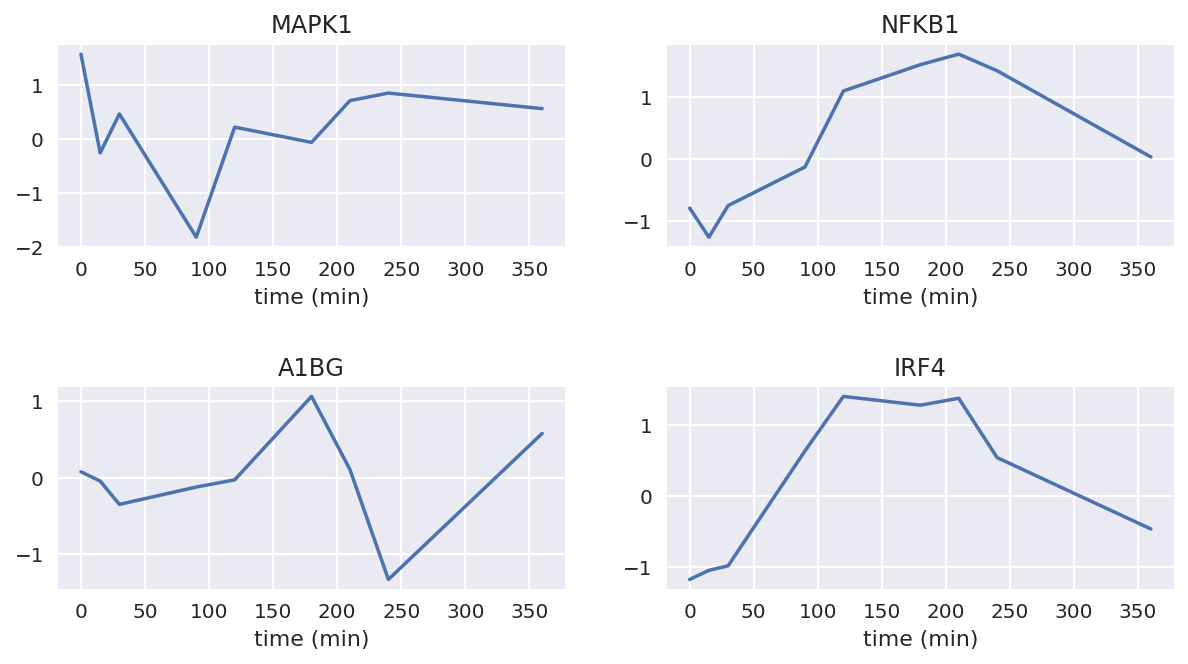

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.7)
for idx, gene in enumerate(['MAPK1', 'NFKB1', 'A1BG', 'IRF4']):
    df = train[train['EffectGene']==gene].iloc[0]
    y = df[[c.endswith('effect') for c in df.index]]
    x = [float(x.split('m')[0]) for x in y.index]
    ax[idx//2][idx%2].plot(x, y)
    ax[idx//2][idx%2].set_title(gene)
    ax[idx//2][idx%2].set_xlabel('time (min)')

In [59]:
res = pd.DataFrame()
for idx, gene in enumerate(['MAPK1', 'NFKB1', 'A1BG', 'IRF4']):
    df = train[train['EffectGene']==gene].iloc[0:1]
    res = pd.concat([res, df])

In [61]:
res[['CauseGene', 'EffectGene', 'Pvalue']]

,CauseGene,EffectGene,Replicate,Treatment,Pvalue,0min_neg_cause,15min_cause,30min_cause,90min_cause,120min_cause,...,0min_neg_effect,15min_effect,30min_effect,90min_effect,120min_effect,180min_effect,210min_effect,240min_effect,360min_effect,Target
151398,MAPK10,MAPK1,1,BCR,0.983,0.280284,0.372051,0.824172,-0.746940,0.472452,...,1.570461,-0.259946,0.461187,-1.821926,0.217530,-0.064708,0.709208,0.849054,0.560650,0
57768,LEF1,NFKB1,1,BCR,0.863,0.777138,0.621560,0.762682,0.949396,-0.388986,...,-0.795316,-1.266743,-0.755123,-0.128786,1.102735,1.528849,1.699936,1.431027,0.033916,0
0,LEF1,A1BG,1,BCR,0.843,0.777138,0.621560,0.762682,0.949396,-0.388986,...,0.077473,-0.044090,-0.349988,-0.122733,-0.027860,1.066276,0.106499,-1.334779,0.580358,0
42642,LEF1,IRF4,1,BCR,0.978,0.777138,0.621560,0.762682,0.949396,-0.388986,...,-1.179309,-1.050650,-0.986710,0.635617,1.404792,1.280665,1.378628,0.540760,-0.466360,0


In [79]:
x1 = res.iloc[0, [c.endswith('cause') for c in res]]
x2 = res.iloc[0, [c.endswith('effect') for c in res]]

In [95]:
np.array(np.outer(x1, x2), dtype='float')

array([[ 0.44017501, -0.07285859,  0.12926326, -0.51065644,  0.0609702 ,
        -0.01813665,  0.19877972,  0.2379761 ,  0.15714109],
       [ 0.58429227, -0.09671314,  0.17158522, -0.67784995,  0.08093239,
        -0.02407475,  0.26386199,  0.31589161,  0.20859049],
       [ 1.29433089, -0.21424006,  0.38009753, -1.50158094,  0.17928235,
        -0.05333067,  0.58451008,  0.6997667 ,  0.46207203],
       [-1.17304033,  0.19416382, -0.34447894,  1.36086917, -0.16248197,
         0.0483331 , -0.52973617, -0.6341922 , -0.41877169],
       [ 0.74196691, -0.12281174,  0.21788848, -0.86077168,  0.10277246,
        -0.03057146,  0.33506667,  0.40113679,  0.26487984],
       [ 0.64879637, -0.10738998,  0.19052771, -0.75268254,  0.08986708,
        -0.02673253,  0.29299155,  0.35076509,  0.23161825],
       [-0.28713658,  0.04752738, -0.08432149,  0.33311328, -0.0397723 ,
         0.01183097, -0.12966871, -0.15523744, -0.10250685],
       [-0.88704515,  0.14682536, -0.26049264,  1.02908004, -0

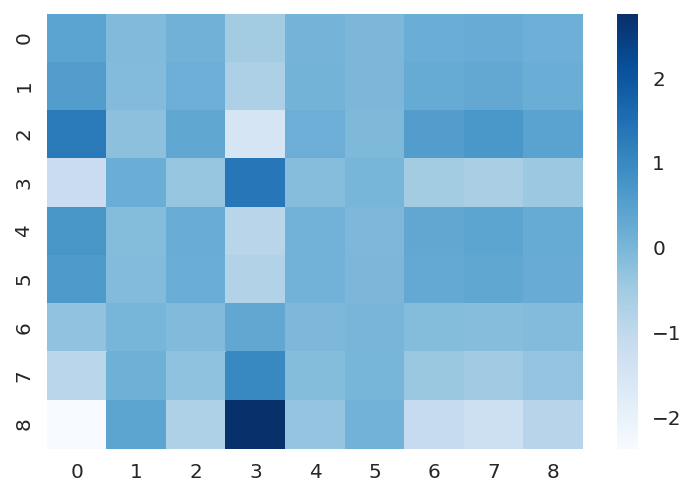

In [99]:
sns.heatmap(np.array(np.outer(x1, x2), dtype='float'), cmap='Blues')

In [14]:
train.head()

,CauseGene,EffectGene,Replicate,Treatment,Pvalue,0min_neg_cause,15min_cause,30min_cause,90min_cause,120min_cause,...,0min_neg_effect,15min_effect,30min_effect,90min_effect,120min_effect,180min_effect,210min_effect,240min_effect,360min_effect,Target
0,MAPK1,A1BG,1,BCR,0.684,1.570461,-0.259946,0.461187,-1.821926,0.217530,...,0.077473,-0.044090,-0.349988,-0.122733,-0.027860,1.066276,0.106499,-1.334779,0.580358,0
1,MAPK1,A1BG,1,CD40,0.684,1.570461,0.540413,-0.058239,-0.384124,0.131689,...,0.077473,0.255573,0.825101,-2.091418,0.986115,0.020539,0.666451,-0.667305,0.313519,0
2,MAPK1,A1BG,2,BCR,0.684,0.814767,-1.303725,0.780416,1.014104,0.493707,...,-0.670996,0.537398,0.592462,0.456636,-0.244272,-1.993159,0.945375,0.301992,1.030175,0
3,MAPK1,A1BG,2,CD40,0.684,0.814767,-1.453817,0.690254,0.163129,0.340793,...,-0.670996,1.808573,-1.767904,-0.623801,-0.330098,1.473550,-0.284614,-1.346430,0.232617,0
4,MAPK1,A1BG,3,BCR,0.684,-1.276183,1.060551,0.513360,-0.863885,-0.520006,...,1.650800,0.196474,-0.110119,-1.663191,0.131282,-0.023995,-0.201010,1.363202,1.410923,0


Text(0.5,1,'Test Pvalues')

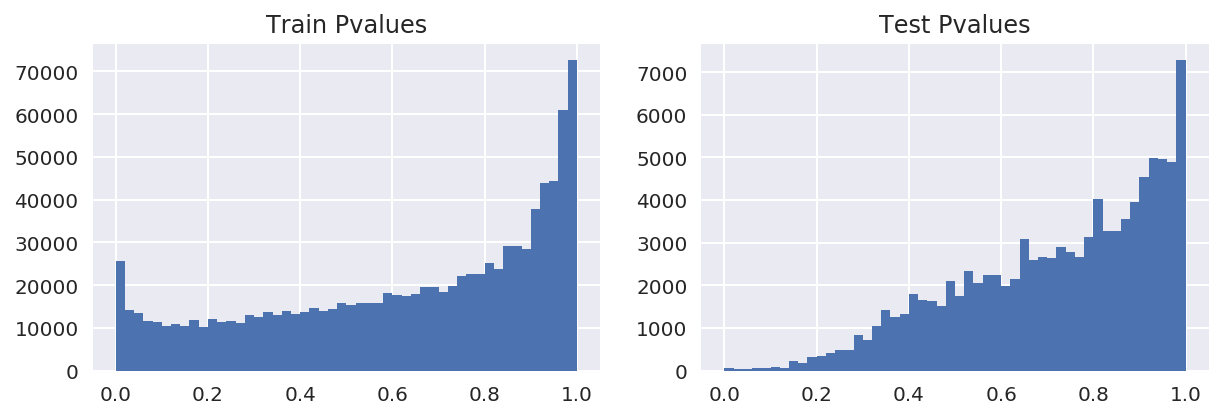

In [64]:
plt.subplots(ncols=2, figsize=(10,3))
plt.subplot(121)
ax = train['Pvalue'].hist(bins=50)
ax.set_title('Train Pvalues')
plt.subplot(122)
ax = test['Pvalue'].hist(bins=50)
ax.set_title('Test Pvalues')

Text(0.5,1,'Test Pvalues')

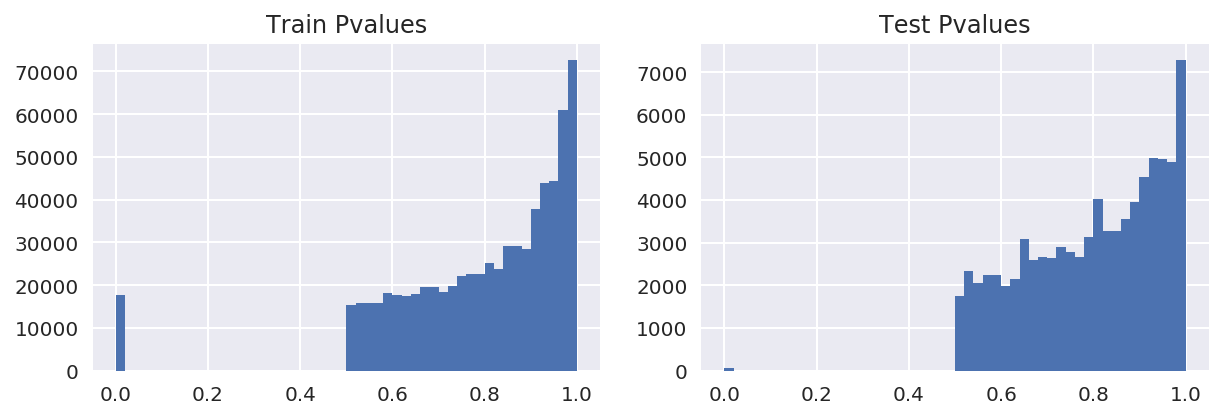

In [15]:
plt.subplots(ncols=2, figsize=(10,3))
plt.subplot(121)
ax = train['Pvalue'].hist(bins=50)
ax.set_title('Train Pvalues')
plt.subplot(122)
ax = test['Pvalue'].hist(bins=50)
ax.set_title('Test Pvalues')

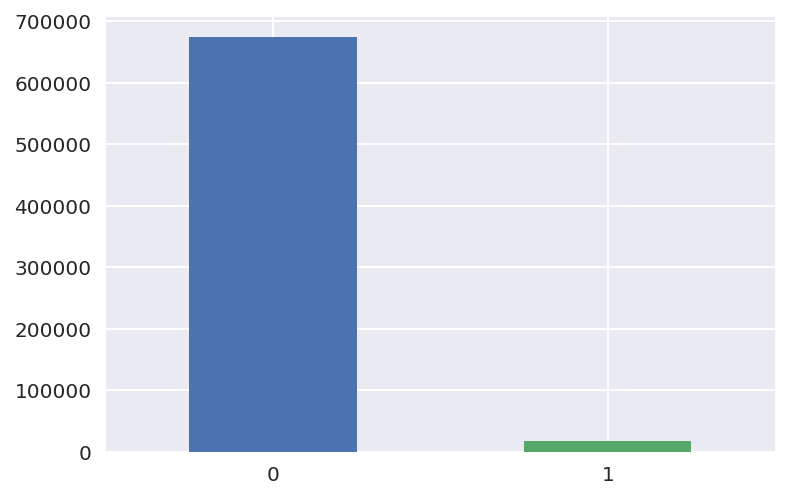

In [67]:
train['Target'].value_counts().plot.bar(rot=0)

In [69]:
test['Target'].value_counts()

0    81978
1       60
Name: Target, dtype: int64

In [68]:
train['Target'].value_counts()

0    673824
1     17718
Name: Target, dtype: int64

In [71]:
train['Target'].value_counts(), test['Target'].value_counts()

(0    687864
 1     17646
 Name: Target, dtype: int64, 0    67938
 1      132
 Name: Target, dtype: int64)

In [73]:
train['Target'].value_counts(), test['Target'].value_counts()

(0    549810
 1     10668
 Name: Target, dtype: int64, 0    205992
 1      7110
 Name: Target, dtype: int64)

In [76]:
17718 / 673824

0.026294700099729305

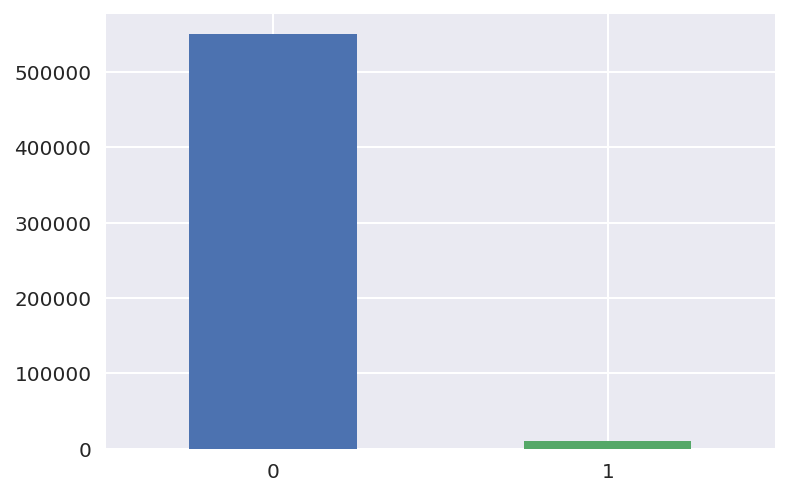

In [75]:
train['Target'].value_counts().plot.bar(rot=0)

In [41]:
len(test[test['Target']==0]) / len(test)

0.9992686316097418

Text(0.5,1,'Test Target')

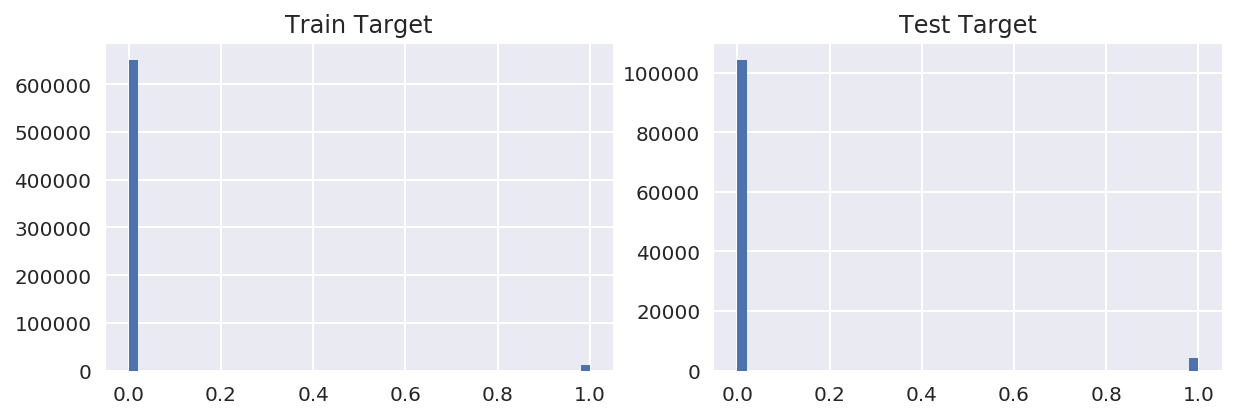

In [92]:
plt.subplots(ncols=2, figsize=(10,3))
plt.subplot(121)
ax = train['Target'].hist(bins=50)
ax.set_title('Train Target')
plt.subplot(122)
ax = test['Target'].hist(bins=50)
ax.set_title('Test Target')

## Evaluate Classifiers

In [18]:
def gmean_score(y, y_pred):
    matrix = confusion_matrix(y, y_pred)
    tn = matrix[0][0]
    tp = matrix[1][1]
    fn = matrix[1][0]
    fp = matrix[0][1]
    return np.sqrt(tp / (tp + fn) * tn / (tn + fp))    

In [80]:
def evaluate_metrics(y, y_pred, y_pred_proba, model='', fold='', desc=''):
    df = pd.DataFrame()
    df.loc[0, 'Model'] = model
    df.loc[0, 'Fold'] = fold
    df.loc[0, 'ROC-AUC'] = roc_auc_score(y, y_pred_proba)
    df.loc[0, 'G-mean'] = gmean_score(y, y_pred)
    df.loc[0, 'F1-Score'] = f1_score(y, y_pred)
    df.loc[0, 'Accuracy'] = accuracy_score(y, y_pred)
    df.loc[0, 'Precision'] = precision_score(y, y_pred)
    df.loc[0, 'Recall'] = recall_score(y, y_pred)    
    df.loc[0, 'Logloss'] = log_loss(y, y_pred_proba)
    df.loc[0, 'Description'] = desc
    print('Confusion matrix:')
    print(confusion_matrix(y, y_pred))
    print(df)
    return df

In [86]:
def evaluate_classifier(model, results, desc=''):
    for test_fold in folds:
        print(f'Test fold: {test_fold}')
        test = pd.read_csv(f'Raw/{test_fold}', sep = ';', dtype=col_types)
        train = pd.DataFrame(columns = test.columns)
        for train_fold in [fold for fold in folds if fold != test_fold]:
            print(f'Train fold: {train_fold}')
            train = pd.concat((train, pd.read_csv(f'Raw/{train_fold}',
                                        sep = ';', dtype=col_types)))
        train = train.reset_index(drop=True)

        test = filter_pvalue(test, (0.01, 0.5))
        train = filter_pvalue(train, (0.01, 0.5))

        print('Evaluating...')
        
        model.fit(train[[col for col in train.columns \
                if 'cause' in col or 'effect' in col]], train['Target'])
        y_pred = model.predict(test[[col for col in test.columns \
                if 'cause' in col or 'effect' in col]])
        y_pred_proba = model.predict_proba(test[[col for col in test.columns \
                if 'cause' in col or 'effect' in col]])[:,1]
        
        model_name = str(model.__class__).split('.')[-1].replace('>','').replace("'",'')
        result = evaluate_metrics(test['Target'], y_pred, y_pred_proba, 
                         model_name, test_fold.split('.')[0], desc)
        
        results = pd.concat((results, result))      
        
    results = results.reset_index(drop=True)
    return results

In [82]:
from lightgbm import LGBMClassifier

In [83]:
results = pd.DataFrame()

In [84]:
results = evaluate_classifier(LGBMClassifier(), results, desc='default')

Test fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[81976     2]
 [   60     0]]
            Model    Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  CTNNB1  0.599173     0.0       0.0  0.999244        0.0   

   Recall   Logloss Description  
0     0.0  0.028031     default  
Test fold: Erk.csv
Train fold: CTNNB1.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[140464      2]
 [   264      0]]
            Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  Erk  0.623835     0.0       0.0   0.99811        0.0   

   Recall   Logloss Description  
0     0.0  0.033098     default  
Test fold: Ikk2.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[104418     18]
 [  4545      3]]
            Model  Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  Ikk2  0.522583  0.025681  0.001313  0.958131   0.142857   

    Recall   Logloss Description  
0  0.00066  0.299633     default  
Test fold: IRF4.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[96586     2]
 [   66     0]]
            Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  IRF4  0.546795     0.0       0.0  0.999296        0.0   

   Recall   Logloss Description  
0     0.0  0.039057     default  
Test fold: Jnk.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[205810    182]
 [  7096     14]]
            Model Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  Jnk  0.557015  0.044354  0.003832  0.965847   0.071429   

     Recall   Logloss Description  
0  0.001969  0.209958     default  
Test fold: LEF1.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[67928    10]
 [  132     0]]
            Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  LEF1  0.638872     0.0       0.0  0.997914        0.0   

   Recall   Logloss Description  
0     0.0  0.047929     default  
Test fold: MYC.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Evaluating...
Confusion matrix:
[[58388    16]
 [ 5597     1]]
            Model Fold  ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  MYC  0.60118  0.013364  0.000356    0.9123   0.058824   

     Recall   Logloss Description  
0  0.000179  0.473882     default  


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [85]:
results

,Model,Fold,ROC-AUC,G-mean,F1-Score,Accuracy,Precision,Recall,Logloss,Description
0,LGBMClassifier,CTNNB1,0.599173,0.000000,0.000000,0.999244,0.000000,0.000000,0.028031,default
0,LGBMClassifier,Erk,0.623835,0.000000,0.000000,0.998110,0.000000,0.000000,0.033098,default
0,LGBMClassifier,Ikk2,0.522583,0.025681,0.001313,0.958131,0.142857,0.000660,0.299633,default
0,LGBMClassifier,IRF4,0.546795,0.000000,0.000000,0.999296,0.000000,0.000000,0.039057,default
0,LGBMClassifier,Jnk,0.557015,0.044354,0.003832,0.965847,0.071429,0.001969,0.209958,default
0,LGBMClassifier,LEF1,0.638872,0.000000,0.000000,0.997914,0.000000,0.000000,0.047929,default
0,LGBMClassifier,MYC,0.601180,0.013364,0.000356,0.912300,0.058824,0.000179,0.473882,default


In [87]:
results = evaluate_classifier(LGBMClassifier(is_unbalance=True), results, desc='is_unbalance')

Test fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[56372 25606]
 [   35    25]]
            Model    Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  CTNNB1  0.568392  0.535276  0.001946   0.68745   0.000975   

     Recall   Logloss   Description  
0  0.416667  0.495957  is_unbalance  
Test fold: Erk.csv
Train fold: CTNNB1.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[102300  38166]
 [   144    120]]
            Model Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  Erk  0.626002  0.575362  0.006226  0.727777   0.003134   

     Recall   Logloss   Description  
0  0.454545  0.480927  is_unbalance  
Test fold: Ikk2.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[103688    748]
 [  4467     81]]
            Model  Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  Ikk2  0.586635  0.132975  0.030128  0.952149   0.097708   

    Recall   Logloss   Description  
0  0.01781  0.192323  is_unbalance  
Test fold: IRF4.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[47078 49510]
 [   31    35]]
            Model  Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  IRF4  0.535977  0.508405  0.001411   0.48744   0.000706   

     Recall   Logloss   Description  
0  0.530303  0.709721  is_unbalance  
Test fold: Jnk.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[197087   8905]
 [  6547    563]]
            Model Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  Jnk  0.619648  0.275247  0.067921   0.92749   0.059463   

     Recall   Logloss   Description  
0  0.079184  0.224323  is_unbalance  
Test fold: LEF1.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[37874 30064]
 [   48    84]]
            Model  Fold   ROC-AUC    G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  LEF1  0.631975  0.595617  0.005548  0.557632   0.002786   

     Recall   Logloss   Description  
0  0.636364  0.726999  is_unbalance  
Test fold: MYC.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Evaluating...
Confusion matrix:
[[58404     0]
 [ 5595     3]]
            Model Fold   ROC-AUC   G-mean  F1-Score  Accuracy  Precision  \
0  LGBMClassifier  MYC  0.669603  0.02315  0.001071  0.912581        1.0   

     Recall   Logloss   Description  
0  0.000536  0.286691  is_unbalance  


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [88]:
results

,Model,Fold,ROC-AUC,G-mean,F1-Score,Accuracy,Precision,Recall,Logloss,Description
0,LGBMClassifier,CTNNB1,0.599173,0.000000,0.000000,0.999244,0.000000,0.000000,0.028031,default
1,LGBMClassifier,Erk,0.623835,0.000000,0.000000,0.998110,0.000000,0.000000,0.033098,default
2,LGBMClassifier,Ikk2,0.522583,0.025681,0.001313,0.958131,0.142857,0.000660,0.299633,default
3,LGBMClassifier,IRF4,0.546795,0.000000,0.000000,0.999296,0.000000,0.000000,0.039057,default
4,LGBMClassifier,Jnk,0.557015,0.044354,0.003832,0.965847,0.071429,0.001969,0.209958,default
5,LGBMClassifier,LEF1,0.638872,0.000000,0.000000,0.997914,0.000000,0.000000,0.047929,default
6,LGBMClassifier,MYC,0.601180,0.013364,0.000356,0.912300,0.058824,0.000179,0.473882,default
7,LGBMClassifier,CTNNB1,0.568392,0.535276,0.001946,0.687450,0.000975,0.416667,0.495957,is_unbalance
8,LGBMClassifier,Erk,0.626002,0.575362,0.006226,0.727777,0.003134,0.454545,0.480927,is_unbalance
9,LGBMClassifier,Ikk2,0.586635,0.132975,0.030128,0.952149,0.097708,0.017810,0.192323,is_unbalance


In [89]:
from xgboost import XGBClassifier

In [90]:
results = evaluate_classifier(XGBClassifier(), results, desc='default')

Test fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[81978     0]
 [   60     0]]
           Model    Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  CTNNB1  0.541579     0.0       0.0  0.999269        0.0   

   Recall   Logloss Description  
0     0.0  0.025109     default  
Test fold: Erk.csv
Train fold: CTNNB1.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[140466      0]
 [   264      0]]
           Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  Erk  0.589961     0.0       0.0  0.998124        0.0   

   Recall   Logloss Description  
0     0.0  0.034247     default  
Test fold: Ikk2.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[104436      0]
 [  4548      0]]
           Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  Ikk2  0.544096     0.0       0.0  0.958269        0.0   

   Recall   Logloss Description  
0     0.0  0.254006     default  
Test fold: IRF4.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[96588     0]
 [   66     0]]
           Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  IRF4  0.512227     0.0       0.0  0.999317        0.0   

   Recall  Logloss Description  
0     0.0  0.03502     default  
Test fold: Jnk.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[205992      0]
 [  7110      0]]
           Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  Jnk  0.569364     0.0       0.0  0.966636        0.0   

   Recall  Logloss Description  
0     0.0  0.17598     default  
Test fold: LEF1.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[67938     0]
 [  132     0]]
           Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  LEF1  0.580766     0.0       0.0  0.998061        0.0   

   Recall   Logloss Description  
0     0.0  0.055468     default  
Test fold: MYC.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[58404     0]
 [ 5598     0]]
           Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  MYC  0.580379     0.0       0.0  0.912534        0.0   

   Recall   Logloss Description  
0     0.0  0.419978     default  


In [91]:
results

,Model,Fold,ROC-AUC,G-mean,F1-Score,Accuracy,Precision,Recall,Logloss,Description
0,LGBMClassifier,CTNNB1,0.599173,0.000000,0.000000,0.999244,0.000000,0.000000,0.028031,default
1,LGBMClassifier,Erk,0.623835,0.000000,0.000000,0.998110,0.000000,0.000000,0.033098,default
2,LGBMClassifier,Ikk2,0.522583,0.025681,0.001313,0.958131,0.142857,0.000660,0.299633,default
3,LGBMClassifier,IRF4,0.546795,0.000000,0.000000,0.999296,0.000000,0.000000,0.039057,default
4,LGBMClassifier,Jnk,0.557015,0.044354,0.003832,0.965847,0.071429,0.001969,0.209958,default
5,LGBMClassifier,LEF1,0.638872,0.000000,0.000000,0.997914,0.000000,0.000000,0.047929,default
6,LGBMClassifier,MYC,0.601180,0.013364,0.000356,0.912300,0.058824,0.000179,0.473882,default
7,LGBMClassifier,CTNNB1,0.568392,0.535276,0.001946,0.687450,0.000975,0.416667,0.495957,is_unbalance
8,LGBMClassifier,Erk,0.626002,0.575362,0.006226,0.727777,0.003134,0.454545,0.480927,is_unbalance
9,LGBMClassifier,Ikk2,0.586635,0.132975,0.030128,0.952149,0.097708,0.017810,0.192323,is_unbalance


In [92]:
results.to_csv('results.csv', index=False)

In [93]:
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    objective="binary:logistic",
    learning_rate=0.07, 
    subsample=.8,
    min_child_weight=6,
    colsample_bytree=.8,
    scale_pos_weight=1.6,
    gamma=10,
    reg_alpha=8,
    reg_lambda=1.3,
)
results = evaluate_classifier(xgb, results, desc='custom')

Test fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[81978     0]
 [   60     0]]
           Model    Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  CTNNB1  0.622935     0.0       0.0  0.999269        0.0   

   Recall   Logloss Description  
0     0.0  0.033899      custom  
Test fold: Erk.csv
Train fold: CTNNB1.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[140455     11]
 [   264      0]]
           Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  Erk  0.657909     0.0       0.0  0.998046        0.0   

   Recall   Logloss Description  
0     0.0  0.039443      custom  
Test fold: Ikk2.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[104436      0]
 [  4548      0]]
           Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  Ikk2  0.605535     0.0       0.0  0.958269        0.0   

   Recall   Logloss Description  
0     0.0  0.265768      custom  
Test fold: IRF4.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[96588     0]
 [   66     0]]
           Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  IRF4  0.527423     0.0       0.0  0.999317        0.0   

   Recall   Logloss Description  
0     0.0  0.051906      custom  
Test fold: Jnk.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: LEF1.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:
[[205992      0]
 [  7110      0]]
           Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  Jnk  0.624316     0.0       0.0  0.966636        0.0   

   Recall   Logloss Description  
0     0.0  0.172499      custom  
Test fold: LEF1.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: MYC.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[67913    25]
 [  132     0]]
           Model  Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  LEF1  0.685018     0.0       0.0  0.997694        0.0   

   Recall  Logloss Description  
0     0.0  0.06492      custom  
Test fold: MYC.csv
Train fold: CTNNB1.csv
Train fold: Erk.csv
Train fold: Ikk2.csv
Train fold: IRF4.csv
Train fold: Jnk.csv
Train fold: LEF1.csv
Evaluating...


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix:
[[58404     0]
 [ 5598     0]]
           Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  \
0  XGBClassifier  MYC  0.642494     0.0       0.0  0.912534        0.0   

   Recall   Logloss Description  
0     0.0  0.402306      custom  


/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
results

,Model,Fold,ROC-AUC,G-mean,F1-Score,Accuracy,Precision,Recall,Logloss,Description
0,LGBMClassifier,CTNNB1,0.599173,0.000000,0.000000,0.999244,0.000000,0.000000,0.028031,default
1,LGBMClassifier,Erk,0.623835,0.000000,0.000000,0.998110,0.000000,0.000000,0.033098,default
2,LGBMClassifier,Ikk2,0.522583,0.025681,0.001313,0.958131,0.142857,0.000660,0.299633,default
3,LGBMClassifier,IRF4,0.546795,0.000000,0.000000,0.999296,0.000000,0.000000,0.039057,default
4,LGBMClassifier,Jnk,0.557015,0.044354,0.003832,0.965847,0.071429,0.001969,0.209958,default
5,LGBMClassifier,LEF1,0.638872,0.000000,0.000000,0.997914,0.000000,0.000000,0.047929,default
6,LGBMClassifier,MYC,0.601180,0.013364,0.000356,0.912300,0.058824,0.000179,0.473882,default
7,LGBMClassifier,CTNNB1,0.568392,0.535276,0.001946,0.687450,0.000975,0.416667,0.495957,is_unbalance
8,LGBMClassifier,Erk,0.626002,0.575362,0.006226,0.727777,0.003134,0.454545,0.480927,is_unbalance
9,LGBMClassifier,Ikk2,0.586635,0.132975,0.030128,0.952149,0.097708,0.017810,0.192323,is_unbalance


In [98]:
results[results['Description']=='is_unbalance'].\
    to_csv('results_lightgbm.csv', index=False)

In [64]:
model = LGBMClassifier()
model.fit(train[[col for col in train.columns if 'cause' in col or 'effect' in col]], train['Target'])
y_pred = model.predict(test[[col for col in test.columns if 'cause' in col or 'effect' in col]])
y_pred_proba = model.predict_proba(test[[col for col in test.columns if 'cause' in col or 'effect' in col]])[:,1]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [67]:
y_pred = model.predict(test[[col for col in test.columns if 'cause' in col or 'effect' in col]])
y_pred_proba = model.predict_proba(test[[col for col in test.columns if 'cause' in col or 'effect' in col]])[:,1]

/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [70]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
evaluate_metrics(test['Target'], y_pred, y_pred_proba)

Confusion matrix:
[[81976     2]
 [   60     0]]
  Model Fold   ROC-AUC  G-mean  F1-Score  Accuracy  Precision  Recall  \
0             0.599173     0.0       0.0  0.999244        0.0     0.0   

    Logloss Description  
0  0.028031              


,Model,Fold,ROC-AUC,G-mean,F1-Score,Accuracy,Precision,Recall,Logloss,Description
0,,,0.599173,0.0,0.0,0.999244,0.0,0.0,0.028031,


In [27]:
evaluate_metrics(test['Target'], y_pred, y_pred_proba)

Confusion matrix:
[[81976     2]
 [   60     0]]


,ROC-AUC,G-mean,F1-Score,Accuracy,Precision,Recall,Logloss
0,0.599173,0.0,0.0,0.999244,0.0,0.0,0.028031


In [25]:
evaluate_metrics(test['Target'], y_pred, y_pred_proba)

Confusion matrix:
[[56372 25606]
 [   35    25]]


,ROC-AUC,G-mean,F1-Score,Accuracy,Precision,Recall,Logloss
0,0.568392,0.535276,0.001946,0.68745,0.000975,0.416667,0.495957


In [ ]:
model = SGDClassifier(loss='log', max_iter=100)
model.fit(train[[col for col in train.columns if 'cause' in col or 'effect' in col]], train['Target'])
y_pred = model.predict(test[[col for col in test.columns if 'cause' in col or 'effect' in col]])
y_pred_proba = model.predict_proba(test[[col for col in test.columns if 'cause' in col or 'effect' in col]])[:,1]